# Q4 Image Segmentation

## 4.1 Load and Segment Satellite Images

### Import necessary libraries

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import Tuple
from sklearn.preprocessing import StandardScaler
import os

### Multivariate Normal PDF

In [17]:
def multivariate_normal_pdf(X: np.ndarray, mean: np.ndarray, cov: np.ndarray) -> np.ndarray:
    """
    Compute the PDF of a multivariate normal distribution.

    X : np.ndarray
        Input data points of shape (n, d) where
        n = number of samples, d = dimension.
    mean : np.ndarray
        Mean vector of shape (d,).
    cov : np.ndarray
        Covariance matrix of shape (d, d).
    
    Returns
    -------
    pdf_values : np.ndarray
        PDF values for each sample, shape (n,).
    """
    X = np.atleast_2d(X)
    mean = np.asarray(mean)
    cov = np.asarray(cov)

    n, d = X.shape

    # Regularize covariance
    eps = 1e-6
    cov_reg = cov + eps * np.eye(cov.shape[0])

    cov_inv = np.linalg.inv(cov_reg)
    cov_det = np.linalg.det(cov_reg)

    # Handle potential negative/zero det due to numerical issues
    if cov_det <= 0:
        cov_det = eps  

    norm_const = 1.0 / np.sqrt((2 * np.pi) ** d * cov_det)

    # Centered data
    diff = X - mean
    exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)

    return norm_const * np.exp(exponent)

### GMM Class

In [18]:
class GMM:
    """
    Gaussian Mixture Model (GMM) implemented using the Expectation-Maximization (EM) algorithm.
    """

    def __init__(self, n_components=3, max_iters=100, tol=1e-6, random_state=None):
        """
        Initialize the GMM model.
        
        n_components : int
            Number of Gaussian components (clusters).
        max_iters : int
            Maximum number of iterations for EM.
        tol : float
            Convergence threshold for log-likelihood.
        random_state : int or None
            Random seed for reproducibility.
        """
        self.n_components = n_components
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state

        # Parameters to be learned
        self.means = None
        self.covariances = None
        self.weights = None

        # For storing likelihood progression
        self.likelihoods = []

    def initialize_parameters(self, X):
        """
        Initialize parameters (means, covariances, weights).
        """
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        data_min = np.min(X, axis=0)
        data_max = np.max(X, axis=0)
        
        # Generate random means uniformly within that range
        self.means = np.random.uniform(data_min, data_max, size=(self.n_components, n_features))

        # Initialize covariances as identity matrices
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])

        # Initialize weights uniformly
        self.weights = np.ones(self.n_components) / self.n_components

    def e_step(self, X):
        """
        E-step: Compute responsibilities (membership probabilities).
        """
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * multivariate_normal_pdf(
                X, mean=self.means[k], cov=self.covariances[k]
            )

        # Normalize responsibilities
        responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
        responsibilities /= np.clip(responsibilities_sum, 1e-12, None)
        
        return responsibilities

    def m_step(self, X, responsibilities):
        """
        M-step: Update parameters (weights, means, covariances).
        """
        n_samples, n_features = X.shape

        # Effective number of points assigned to each cluster
        Nk = responsibilities.sum(axis=0)  

        # Update weights
        self.weights = Nk / n_samples

        # Update means
        self.means = (responsibilities.T @ X) / Nk[:, np.newaxis]

        # Update covariances
        self.covariances = np.zeros((self.n_components, n_features, n_features))
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covariances[k] = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff / Nk[k]

    def compute_likelihood(self, X):
        """
        Compute the overall log-likelihood of the dataset under current parameters.
        """
        likelihood = np.zeros(X.shape[0])
        for k in range(self.n_components):
            likelihood += self.weights[k] * multivariate_normal_pdf(
                X, mean=self.means[k], cov=self.covariances[k]
            )
        eps = 1e-12  # small constant to avoid log(0)
        return np.sum(np.log(np.clip(likelihood, eps, None)))

    def fit(self, X):
        """
        Fit the GMM model using the EM algorithm.
        
        X : ndarray of shape (n_samples, n_features)
            Input dataset.
        """
        self.initialize_parameters(X)

        for _ in range(self.max_iters):
            # E-step
            responsibilities = self.e_step(X)

            # M-step
            self.m_step(X, responsibilities)

            # Compute log-likelihood
            log_likelihood = self.compute_likelihood(X)
            self.likelihoods.append(log_likelihood)

            # Check convergence
            if len(self.likelihoods) > 1 and abs(self.likelihoods[-1] - self.likelihoods[-2]) < self.tol:
                break

    def getMembership(self, X):
        """
        Return the membership (responsibility) values for each sample.
        
        X : ndarray of shape (n_samples, n_features)
            Input dataset.
        
        Returns
        -------
        responsibilities : ndarray of shape (n_samples, n_components)
            Membership values for each sample.
        """
        return self.e_step(X)

    def getLikelihood(self):
        """
        Return the overall likelihood values stored during training.
        
        Returns
        -------
        likelihoods : list
            Log-likelihood values over iterations.
        """
        return self.likelihoods

    def drawLikelihood(self):
        """
        Plot likelihood vs iterations.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.likelihoods, marker='o')
        plt.title("Log-Likelihood vs Iterations", fontsize=16)
        plt.xlabel("Iteration", fontsize=14)
        plt.ylabel("Log-Likelihood", fontsize=14)
        plt.grid(True)
        plt.text(
            0.95, 0.95, "m.samartha",
            ha='right', va='top',
            transform=plt.gca().transAxes,
            fontsize=10, color='gray', alpha=0.7
        )
        plt.show()

### Image Segmenter Class

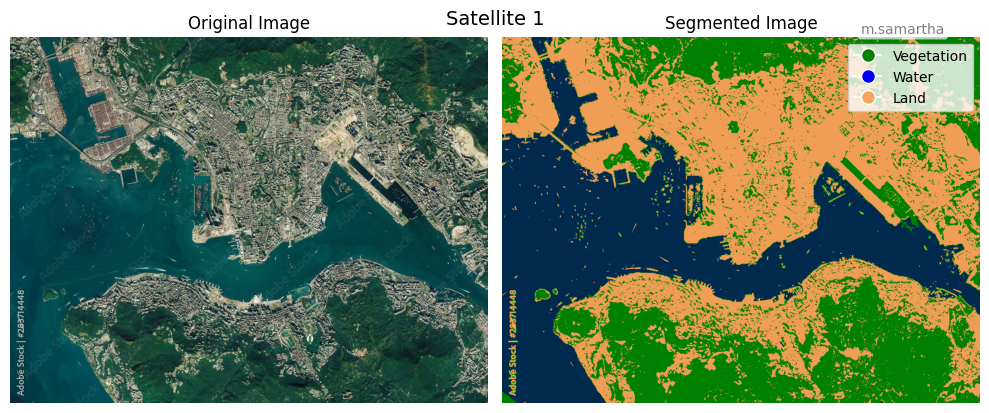

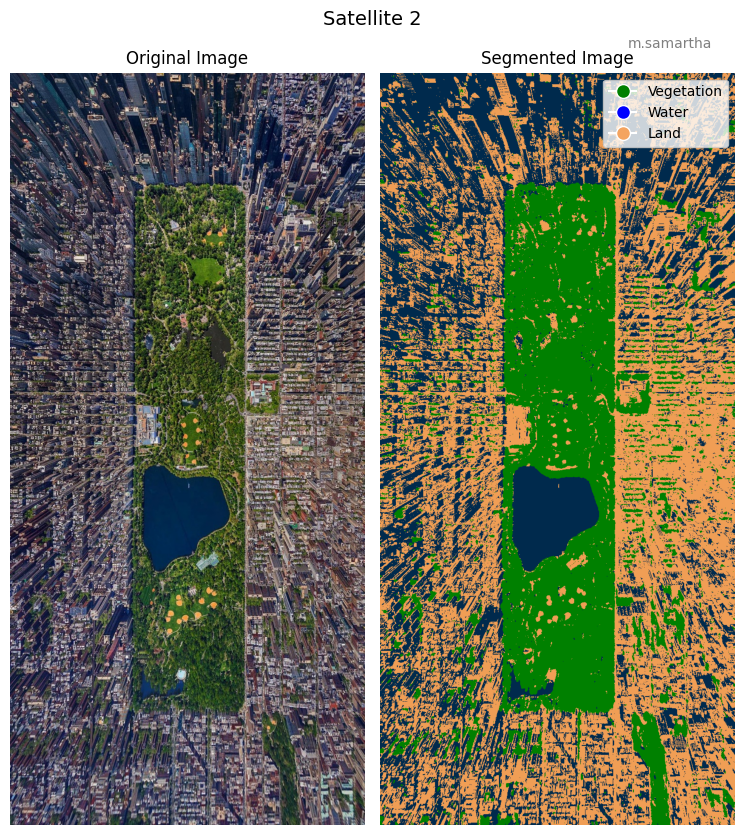

In [19]:
class ImageSegmenter:
    """
    Perform image segmentation using a custom Gaussian Mixture Model (GMM).

    gmm : object
        Custom GMM object
    k : int
        Number of Gaussian components (clusters).
    """

    def __init__(self, gmm, k: int = 3):
        """
        Initialize the ImageSegmenter.

        gmm : object
            Custom GMM model instance.
        k : int
            Number of clusters for segmentation (default is 3).
        """
        self.gmm = gmm
        self.k = k
        self.scaler = StandardScaler()
        self.original_shape = None

    def load_image(self, path: str) -> np.ndarray:
        """
        Load an image from disk.

        path : str
            Path to the image file.

        Returns
        -------
        img : np.ndarray
            Image in RGB format.
        """
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

    def preprocess(self, img: np.ndarray) -> Tuple[np.ndarray, Tuple[int, int, int]]:
        """
        Flatten and normalize image for GMM input.

        img : np.ndarray
            Input RGB image.

        Returns
        -------
        flat_img : np.ndarray
            Flattened image of shape (n_pixels, n_channels).
        """
        h, w, c = img.shape
        self.original_shape = (h, w, c)
        flat_img = img.reshape(-1, c).astype(np.float64)

        flat_img = self.scaler.fit_transform(flat_img)

        return flat_img, (h, w, c)

    def segment(self, img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Segment the input image using GMM.

        img : np.ndarray
            Input RGB image.

        Returns
        -------
        segmented_img : np.ndarray
            Segmented image with distinct colors.
        labels : np.ndarray
            Cluster assignments for each pixel.
        """
        flat_img, original_shape = self.preprocess(img)

        # Fit GMM
        self.gmm.fit(flat_img)

        # Predict cluster labels
        responsibilities = self.gmm.e_step(flat_img)
        labels = np.argmax(responsibilities, axis=1)

        # Map labels to distinct colors
        colors = np.array([
            [240, 158, 85], # Sandy Brown -> Land
            [0, 128, 0],   # Green -> Vegetation
            [0, 42, 77]   # Blue -> Water
        ])

        segmented_img = colors[labels].reshape(img.shape).astype(np.uint8)

        return segmented_img, labels

    def visualize(self, original: np.ndarray, segmented: np.ndarray, title: str = ""):
        """
        Show original and segmented images side by side.

        original : np.ndarray
            Original RGB image.
        segmented : np.ndarray
            Segmented image.
        title : str, optional
            Title for the visualization.
        """
        h, w, _ = self.original_shape
        plt.figure(figsize=(w/100, h/175), dpi=100)
        plt.subplot(1, 2, 1)
        plt.imshow(original)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(segmented)
        plt.title("Segmented Image")
        plt.axis("off")
        plt.tight_layout()
        plt.legend(handles=[
            plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='g', markersize=10, label='Vegetation'),
            plt.Line2D([0], [0], marker='o', color='w',
                            markerfacecolor='b', markersize=10, label='Water'),
            plt.Line2D([0], [0], marker='o', color='w',
                            markerfacecolor='sandybrown', markersize=10, label='Land')
        ])

        # Use annotation instead of text for better visibility and set background
        plt.gcf().text(
            0.95, 0.95, "m.samartha",
            ha='right', va='top',
            fontsize=10, color='gray',
            bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, edgecolor='none')
        )

        if title:
            plt.suptitle(title, fontsize=14)
        plt.show()
    
    def create_dynamic_video(self, img: np.ndarray, output_path: str, fps: int = 2):
        """
        Generate a dynamic visualization video of the GMM fitting process.

        img : np.ndarray
            Input RGB image.
        output_path : str
            Path to save the output video (e.g., 'output.avi').
        fps : int, optional
            Frames per second for the output video (default is 2).
        """
        flat_img, _ = self.preprocess(img)
    
        # Initialize GMM
        self.gmm.initialize_parameters(flat_img)
        self.gmm.likelihoods = []

        # Setup video writer
        h, w, _ = img.shape
        frame_h, frame_w = h, w * 3   # 3 panels side-by-side
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        video = cv2.VideoWriter(output_path, fourcc, fps, (frame_w, frame_h))

        # Iterate EM steps manually
        for iteration in range(self.gmm.max_iters):
            # E-step
            responsibilities = self.gmm.e_step(flat_img)
            labels = np.argmax(responsibilities, axis=1)

            # M-step
            self.gmm.m_step(flat_img, responsibilities)

            # Compute log-likelihood
            log_likelihood = self.gmm.compute_likelihood(flat_img)
            self.gmm.likelihoods.append(log_likelihood)

            # ---- Panel 1: Original image ----
            panel1 = img.copy()

            # ---- Panel 2: Segmented image ----

            # Get the GMM's cluster means (which are currently in the scaled space).
            scaled_means = self.gmm.means

            # Use the scaler object to perform a proper inverse transform.
            mean_colors_rgb = self.scaler.inverse_transform(scaled_means)

            # Clip the values to the valid [0, 255] color range and convert to integer type.
            mean_colors_rgb = np.clip(mean_colors_rgb, 0, 255).astype(np.uint8)
            panel2 = mean_colors_rgb[labels].reshape(self.original_shape)
            
            # ---- Panel 3: Log-likelihood plot ----
            # declare size similar to other panels
            plt.figure(figsize=(w / 100, h / 100), dpi=100)
            plt.plot(self.gmm.likelihoods, marker='o', color='b')
            plt.title("Log-Likelihood")
            plt.xlabel("Iteration")
            plt.ylabel("Value")
            plt.grid(True)
            plt.tight_layout()

            # Save plot as an image
            plot_path = "_temp_plot.png"
            plt.savefig(plot_path)
            plt.close()

            panel3 = cv2.imread(plot_path)
            panel3 = cv2.cvtColor(panel3, cv2.COLOR_BGR2RGB)
            panel3 = cv2.resize(panel3, (w, h))

            # ---- Concatenate panels ----
            frame = np.hstack((panel1, panel2, panel3))
            video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

            # Stop if converged
            if iteration > 1 and abs(self.gmm.likelihoods[-1] - self.gmm.likelihoods[-2]) < self.gmm.tol:
                break

        video.release()
        print(f"Video saved to {output_path}")

seed = 62

# Initialize custom GMM and segmenter
gmm = GMM(n_components=3, max_iters=100, random_state=seed)   
segmenter = ImageSegmenter(gmm, k=3)

# Segment both satellite images
for i in [1, 2]:
    img_path = f"Dataset/satellite_{i}.png"  # Update path if needed
    img = segmenter.load_image(img_path)
    segmented_img, labels = segmenter.segment(img)
    segmenter.visualize(img, segmented_img, title=f"Satellite {i}")
    

### Observations and Results
We see that the image segmentation works quite well for the first image with the land, water, and vegetation being segmented quite well. However, for the second image, the model is not able to distinguish between the blue glass buildings and the water body, and hence segments them into the same cluster. This could be due to the fact that both have similar RGB values. However, it is able to segment other parts of the land and vegetation quite well.

## 4.2 Dynamic Visualization Video

In [21]:
# Create dynamic videos for both images
for i in [1, 2]:
    img_path = f"Dataset/satellite_{i}.png"  
    img = segmenter.load_image(img_path)    

    # Create dynamic video
    segmenter.create_dynamic_video(img, f"satellite_{i}_process.mp4", fps=2)
    # Delete temp_plot.png if exists
    if os.path.exists("_temp_plot.png"):
        os.remove("_temp_plot.png") 

Video saved to satellite_1_process.mp4
Video saved to satellite_2_process.mp4


### Link to the Onedrive folder with videos
[Click Here](https://iiithydstudents-my.sharepoint.com/:f:/g/personal/m_samartha_students_iiit_ac_in/EpZqUEG36hJGvHGku_7QHLABVFyUfIjTHRHFcWKWnlmwlg?e=TVH8PA)